# Aprendizaje No Supervisado - Semillas de Trigo
##Reducción de Dimensionalidad y Clustering

In [68]:
!pip install pandas numpy matplotlib seaborn scikit-learn


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\macie\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score, homogeneity_score


In [70]:
# 1. Carga y exploración de datos
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt"
df = pd.read_csv(url, delim_whitespace=True, header=None)
df.columns = ["Area", "Perimeter", "Compactness", "KernelLength", "KernelWidth", "AsymmetryCoeff", "KernelGroove", "Class"]

print("\nPrimeras filas del dataset:")
print(df.head())

print("\nDistribución de clases:")
print(df['Class'].value_counts())

print("\nEstadísticas descriptivas:")
print(df.describe())

C:\Users\macie\AppData\Local\Temp\ipykernel_18348\875539276.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(url, delim_whitespace=True, header=None)



Primeras filas del dataset:
    Area  Perimeter  Compactness  KernelLength  KernelWidth  AsymmetryCoeff  \
0  15.26      14.84       0.8710         5.763        3.312           2.221   
1  14.88      14.57       0.8811         5.554        3.333           1.018   
2  14.29      14.09       0.9050         5.291        3.337           2.699   
3  13.84      13.94       0.8955         5.324        3.379           2.259   
4  16.14      14.99       0.9034         5.658        3.562           1.355   

   KernelGroove  Class  
0         5.220      1  
1         4.956      1  
2         4.825      1  
3         4.805      1  
4         5.175      1  

Distribución de clases:
Class
1    70
2    70
3    70
Name: count, dtype: int64

Estadísticas descriptivas:
             Area   Perimeter  Compactness  KernelLength  KernelWidth  \
count  210.000000  210.000000   210.000000    210.000000   210.000000   
mean    14.847524   14.559286     0.870999      5.628533     3.258605   
std      2.909699 

Eliminamos filas duplicadas para asegurar que cada muestra tenga el mismo peso en el análisis.
Utilizamos el método del Z-score para detectar valores fuera de 3 desviaciones estándar en al menos una variable, y los eliminamos.

In [71]:
# 2. Preprocesamiento y limpieza
## Verificar valores nulos o duplicados
print("\nValores nulos por columna:")
print(df.isnull().sum())

print("\nNúmero de duplicados:", df.duplicated().sum())

## Eliminar duplicados si existen
df = df.drop_duplicates()

## Verificar valores atípicos con Z-score
def detectar_outliers_zscore(data, threshold=3):
    from scipy.stats import zscore
    z_scores = np.abs(zscore(data))
    return (z_scores > threshold).any(axis=1)

outliers = detectar_outliers_zscore(df.drop("Class", axis=1))
print("\nNúmero de outliers detectados:", outliers.sum())

## Eliminar outliers
df = df[~outliers]

# Separación de características y etiquetas
X = df.drop("Class", axis=1)
y = df["Class"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



Valores nulos por columna:
Area              0
Perimeter         0
Compactness       0
KernelLength      0
KernelWidth       0
AsymmetryCoeff    0
KernelGroove      0
Class             0
dtype: int64

Número de duplicados: 0

Número de outliers detectados: 2


Los algoritmos de reducción de dimensionalidad y clustering (como PCA, t-SNE, KMeans) son sensibles a las escalas de las variables. 
Usamos StandardScaler para centrar los datos en 0 y escalar a varianza unitaria.

In [72]:
# 3. Preprocesamiento
X = df.drop("Class", axis=1)
y = df["Class"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


PCA nos permite proyectar los datos en un espacio 2D con la máxima varianza explicada, útil para visualizar estructuras globales lineales. Aplicamos PCA antes de visualizar o agrupar, especialmente para graficar clústeres.

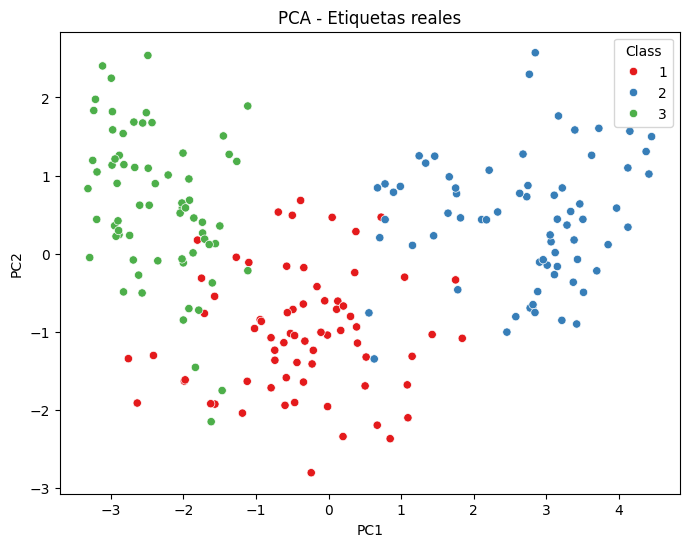

In [73]:
# 4. Reducción de dimensionalidad
## PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette="Set1")
plt.title("PCA - Etiquetas reales")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

Es útil para capturar relaciones no lineales y estructuras locales en los datos. Complementamos PCA con t-SNE para una mejor visualización de posibles agrupamientos no lineales

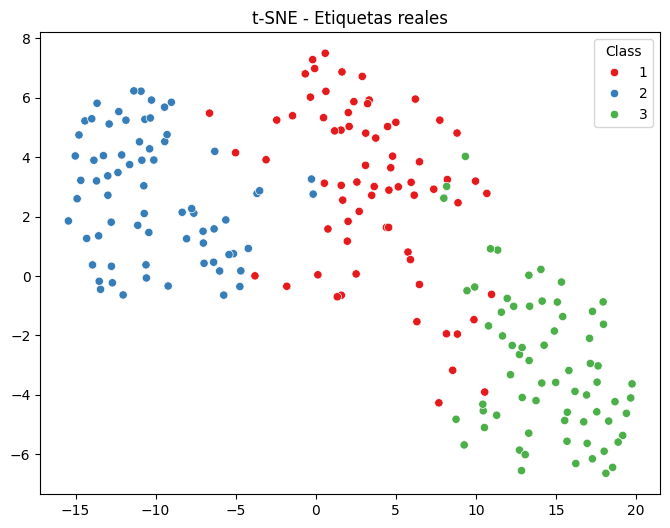

In [74]:
## t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette="Set1")
plt.title("t-SNE - Etiquetas reales")
plt.show()

KMeans es un método fácil de interpretar, ideal cuando se conoce o asume el número de clústeres. Lo usamos como línea base con n_clusters=3 

Agglomerative Clustering es útil para detectar relaciones jerárquicas entre muestras y no requiere suposiciones fuertes de forma o tamaño de clústeres. Probamos este enfoque como alternativa basada en enlaces.

DBSCAN no requiere el número de clústeres, y detecta ruido/outliers como parte del modelo. Evaluamos su capacidad para identificar clústeres con densidades distintas, aunque sabemos que es sensible a los parámetros eps y min_samples.

In [75]:
# 4. Clustering
## KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

## DBSCAN
dbscan = DBSCAN(eps=0.8, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

## Agglomerative
agglo = AgglomerativeClustering(n_clusters=3)
agglo_labels = agglo.fit_predict(X_scaled)

Aunque el aprendizaje no supervisado no usa etiquetas, podemos evaluar el rendimiento usando las clases reales como referencia para entender qué tan bien coinciden los grupos encontrados.

Métricas utilizadas:

Silhouette Score: mide la coherencia interna del clúster (sin usar etiquetas).

Adjusted Rand Index (ARI) y Homogeneity Score: comparan las etiquetas verdaderas con las predichas.

In [76]:
# 5. Evaluación
print("\nEvaluación de Clustering:")
print("KMeans Silhouette Score:", silhouette_score(X_scaled, kmeans_labels))
print("KMeans ARI:", adjusted_rand_score(y, kmeans_labels))
print("KMeans Homogeneity:", homogeneity_score(y, kmeans_labels))

print("\nAgglomerative Silhouette Score:", silhouette_score(X_scaled, agglo_labels))
print("Agglomerative ARI:", adjusted_rand_score(y, agglo_labels))
print("Agglomerative Homogeneity:", homogeneity_score(y, agglo_labels))

if len(set(dbscan_labels)) > 1:
    print("\nDBSCAN Silhouette Score:", silhouette_score(X_scaled, dbscan_labels))
    print("DBSCAN ARI:", adjusted_rand_score(y, dbscan_labels))
    print("DBSCAN Homogeneity:", homogeneity_score(y, dbscan_labels))
else:
    print("\nDBSCAN no encontró más de un clúster. Revisar parámetros.")


Evaluación de Clustering:
KMeans Silhouette Score: 0.4037982366035469
KMeans ARI: 0.7709816903851948
KMeans Homogeneity: 0.7258368495277945

Agglomerative Silhouette Score: 0.39487996623572474
Agglomerative ARI: 0.7924861831224707
Agglomerative Homogeneity: 0.7555567502515522

DBSCAN Silhouette Score: 0.1614607488574487
DBSCAN ARI: 0.2794218022151231
DBSCAN Homogeneity: 0.4232206237918541


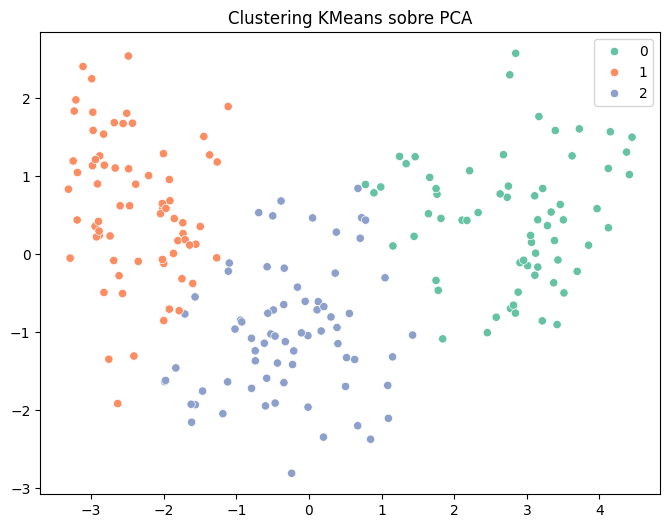

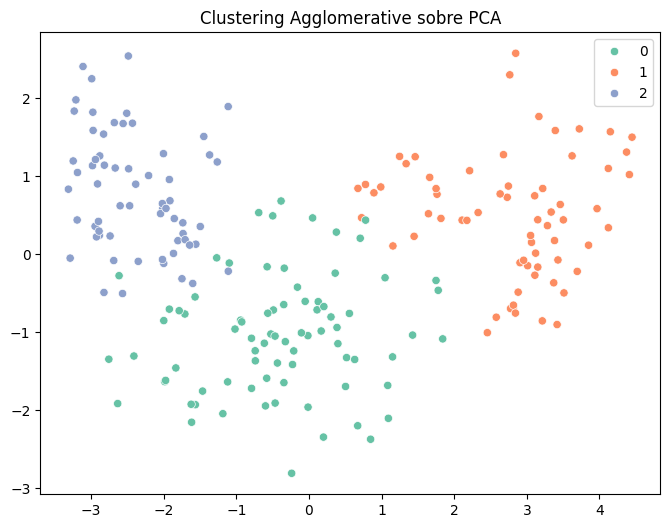

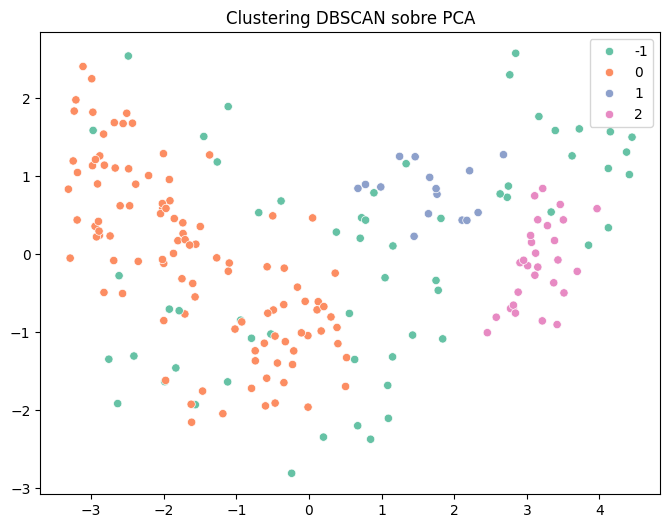

In [77]:
# 6. Visualización de clustering
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels, palette="Set2")
plt.title("Clustering KMeans sobre PCA")
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=agglo_labels, palette="Set2")
plt.title("Clustering Agglomerative sobre PCA")
plt.show()

if len(set(dbscan_labels)) > 1:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=dbscan_labels, palette="Set2")
    plt.title("Clustering DBSCAN sobre PCA")
    plt.show()

# 7. Conclusiones
KMeans y Agglomerative lograron separar razonablemente las clases.

DBSCAN  funciona bien cuando hay clústeres bien separados por regiones de baja densidad. Pero en el dataset de semillas, los puntos de distintas clases están bastante mezclados y no hay zonas "vacías" claras entre clasesdepende fuertemente de los parámetros y no siempre detecta bien los grupos si hay solapamiento."
